In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

In [2]:
data_set = pd.read_csv("samsung.csv")

In [3]:
data_set
# open : 시가
# high : 고가
# low : 저가
# close : 종가
# volume : 거래량

,Date,Open,High,Low,Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,74195000.0
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,74680000.0
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,54390000.0
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,40305000.0
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,46880000.0
...,...,...,...,...,...,...
5249,2020-11-17,67000.0,67000.0,65600.0,65700.0,30204089.0
5250,2020-11-18,65700.0,66200.0,64700.0,64800.0,22963790.0
5251,2020-11-19,64100.0,64800.0,63900.0,64600.0,16590290.0
5252,2020-11-20,63900.0,65200.0,63900.0,64700.0,15068682.0


In [4]:
data_set["Date"] = pd.to_datetime(data_set["Date"], format="%Y-%m-%d %H:%M:%S")
data_set["Year"] = data_set["Date"].dt.year
data_set["Month"] = data_set["Date"].dt.month
data_set["Day"] = data_set["Date"].dt.day

In [5]:
data_set = data_set.dropna()

Text(0, 0.5, 'price')

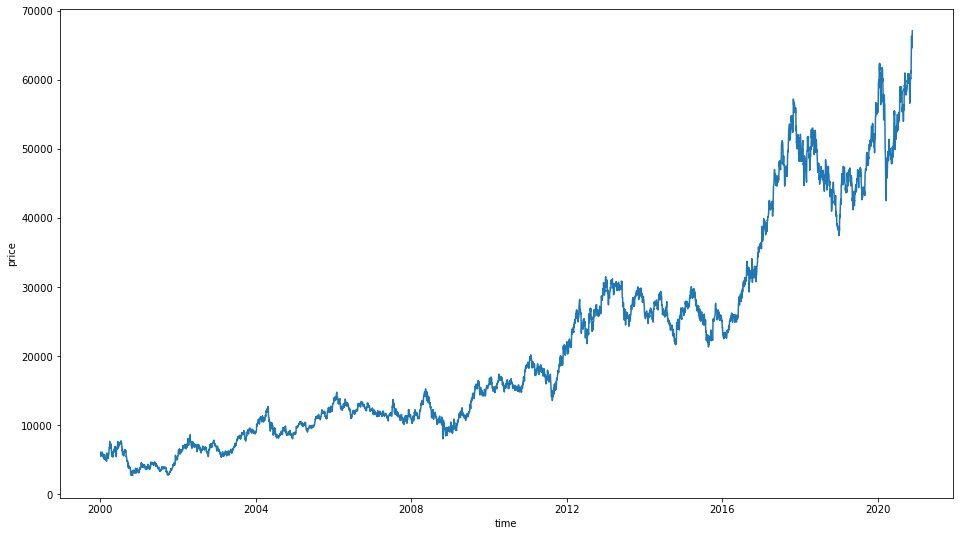

In [6]:
import seaborn as sns

plt.figure(figsize=(16, 9))
sns.lineplot(y=data_set["Close"], x=data_set["Date"])
plt.xlabel('time')
plt.ylabel('price')

In [7]:
high_price = data_set["High"].values
low_price = data_set["Low"].values
mid_price = (high_price + low_price)/2

In [8]:
# window 만들기
# 50일까지의 데이터로 학습, 51일 데이터를 예측

seq_len = 50
squence_len = seq_len + 1

res = []
for i in range(len(mid_price) - squence_len):
    res.append(mid_price[i:i+squence_len])

In [9]:
# 정규화
# 읽기 어려운 데이터들을 한눈에 볼 수 있게 미니어쳐화 시킴
normalized_data = []
for window in res:
    normalized_window = [((float(p)/float(window[0]))-1) for p in window]
    normalized_data.append(normalized_window)
res = np.array(normalized_data)

In [10]:
res

array([[ 0.        , -0.01614274, -0.03483432, ..., -0.0382328 ,
        -0.09515718, -0.10450297],
       [ 0.        , -0.01899827, -0.04749568, ..., -0.08031088,
        -0.08981002, -0.09153713],
       [ 0.        , -0.0290493 , -0.00088028, ..., -0.0721831 ,
        -0.07394366, -0.04225352],
       ...,
       [ 0.        , -0.01158645,  0.00802139, ...,  0.16399287,
         0.18181818,  0.16666667],
       [ 0.        ,  0.01983769,  0.04508566, ...,  0.19567178,
         0.18034265,  0.16050496],
       [ 0.        ,  0.02475685,  0.03536693, ...,  0.15738285,
         0.13793103,  0.14146773]])

In [11]:
# Divide Train_set and Test_set

row = int(round(res.shape[0]*0.9))
train = res[:row, :]
np.random.shuffle(train)

# x_train에 50개 넣고 y_train에 마지막 1개
x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:, -1]

# x_test에 50개 넣고 y_test에 마지막 1개
x_test = res[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = res[row:, -1]

x_train.shape, x_test.shape

((4673, 50, 1), (519, 50, 1))

In [12]:
# 학습을 시켜봅시다
# LSTM LSTM DENSE

model = Sequential()

# LSTM 50개 가져오기
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
# LSTM 한번 더
model.add(LSTM(64, return_sequences=False))
# 다음날 하루의 가격 예측
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="rmsprop")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=10, epochs=20)

Epoch 1/20
468/468 [==============================] - 17s 36ms/step - loss: 0.0016 - val_loss: 5.0450e-04
Epoch 2/20
468/468 [==============================] - 16s 33ms/step - loss: 6.0784e-04 - val_loss: 5.3372e-04
Epoch 3/20
468/468 [==============================] - 16s 35ms/step - loss: 4.5508e-04 - val_loss: 2.3348e-04
Epoch 4/20
468/468 [==============================] - 16s 34ms/step - loss: 4.4908e-04 - val_loss: 4.7435e-04
Epoch 5/20
468/468 [==============================] - 16s 33ms/step - loss: 4.3781e-04 - val_loss: 3.5473e-04
Epoch 6/20
468/468 [==============================] - 16s 35ms/step - loss: 4.4099e-04 - val_loss: 3.3903e-04
Epoch 7/20
468/468 [==============================] - 16s 35ms/step - loss: 4.3051e-04 - val_loss: 3.3554e-04
Epoch 8/20
468/468 [==============================] - 16s 33ms/step - loss: 4.2600e-04 - val_loss: 4.0031e-04
Epoch 9/20
468/468 [==============================] - 16s 34ms/step - loss: 4.2704e-04 - val_loss: 2.4105e-04
Epoch 10/20
46

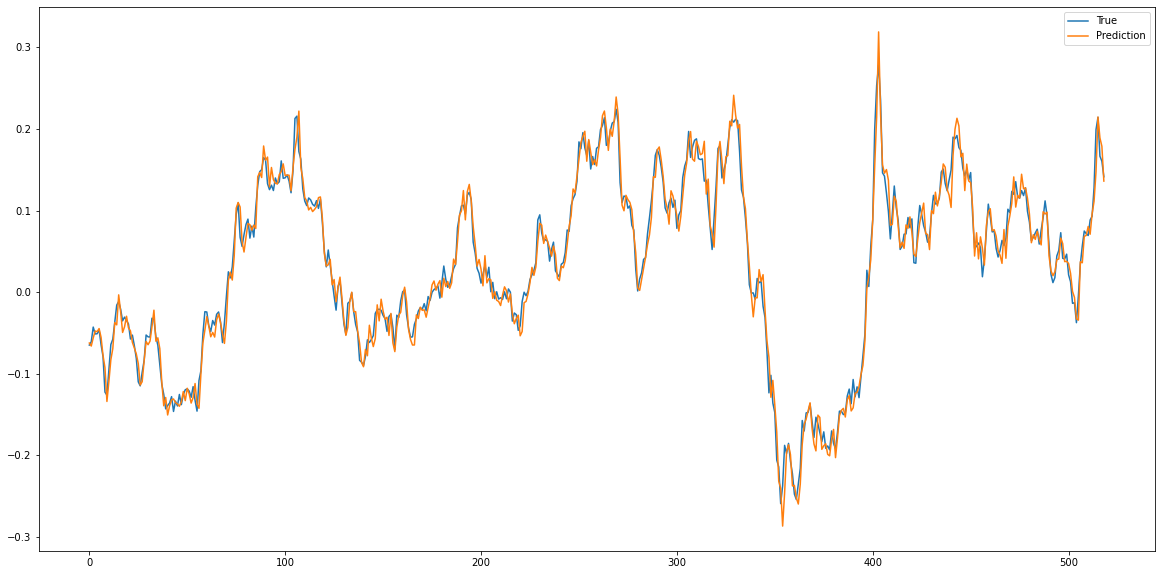

In [15]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()